In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
#import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cycler import cycler
import os
import itertools
import seaborn as sns
import ratmetab
if os.getlogin() == 'jonesa7':
    import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Rationale

Discover metabolic changes between aged impaired (AI) and aged unimpaired (AU) rats.  Also, compare both of these to young (Y) rats.

## Import data

We read and quality filter data sets.  There are four of them:
1. brain new
1. blood new
1. brain old
1. blood old

There are two quality filters, that, for each data set, remove metabolites...
1. ...with $\le 1$ observed (non-missing) value in any rat group (filter 1)
1. ...with $\le 80 \%$ observed (non-missing) values (filter 2)

The result is data frames of metabolite levels, whose rows are samples (one from each rat), and whose columns are metabolite code names.  These code names are converted into scientific metabolite names using `Rat_codebook_27_Oct_2022.csv`

In [2]:
codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
data = ratmetab.read_all_data()
data['brain']

,LIscore,Group,Cholic acid,Taurocholic acid,Taurochenodeoxycholic acid,Tauromuricholic acid (alpha + beta),Carnitine,Acetylcarnitine,Propionylcarnitine,Malonylcarnitine (Hydroxybutyrylcarnitine),...,Dihydroceramide C10:1,Ceramide C14:0,Ceramide C15:1,2-Hydroxyacylceramide C20:0,2-Hydroxyacyldihydroceramide C28:0,Phosphatidylethanolamine aa 20:0,Phosphatidylethanolamine aa 22:2,Phosphatidylethanolamine ae 38:2,Phosphatidylethanolamine ae 42:1,Phosphatidylserine aa 40:5
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,NaN,NaN,NaN,NaN,11.034,1.521,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1158,201,AU,NaN,0.32700,0.03300,0.27960,10.904,4.107,0.142000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1172,155,AU,NaN,0.37800,0.01784,0.21040,10.132,4.187,0.072465,0.060798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,194,AU,NaN,0.14600,NaN,0.06520,10.024,4.249,0.146000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,291,AI,NaN,NaN,NaN,NaN,11.611,3.001,NaN,0.077633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,200,Y,NaN,0.05720,0.01228,0.08160,41.726,10.425,NaN,0.296000,...,NaN,0.01079,NaN,0.11100,0.0084,0.108,0.199,0.476,0.562,39.963
298,212,Y,0.0544,0.02564,0.01232,0.02828,40.899,10.093,NaN,0.258000,...,NaN,0.00782,NaN,0.07611,NaN,0.100,0.175,0.364,0.390,NaN
427,218,Y,NaN,0.11200,NaN,0.03304,44.390,7.729,NaN,0.216000,...,0.00094,0.01136,NaN,0.05706,NaN,0.393,0.348,NaN,0.586,44.008


In [3]:
if os.getlogin() == 'jonesa7':
    codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
    datapath = {
        'blood new': 'blood_27_Oct_2022',
        'brain new': 'brain_27_Oct_2022',
        'blood old': 'old_blood_17_Nov_2022',
        'brain old': 'old_brain_17_Nov_2022',
               }
    excluded_metabolites = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True, return_m2exclude=True) for k, v in datapath.items()}
    excluded_metabolites_cons = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=False, return_m2exclude=True) for k, v in datapath.items()}
else:
    datapath_blood = 'some/path'
    datapath_brain = 'some/path'
    codebookpath = 'some/path'


excluded_metabolites.update({tissue: set(excluded_metabolites[tissue + ' new']).intersection(set(excluded_metabolites[tissue + ' old'])) for tissue in ['blood', 'brain']})
excluded_metabolites_cons.update({tissue: set(excluded_metabolites_cons[tissue + ' new']).intersection(set(excluded_metabolites_cons[tissue + ' old'])) for tissue in ['blood', 'brain']})

/Users/jonesa7/CTNS/notebooks/src/ratmetab.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  excluded_metabolites = codebook.loc[metabolites2exclude_in_codebook, 'MetaboliteName'].to_list()
/Users/jonesa7/CTNS/notebooks/src/ratmetab.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  excluded_metabolites = codebook.loc[metabolites2exclude_in_codebook, 'MetaboliteName'].to_list()
/Users/jonesa7/CTNS/notebooks/src/ratmetab.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  excluded_metabolites = codebook.loc[metabolites2exclude_in_codebook, 'MetaboliteName'].to_list()
/Users/jonesa7/CTNS/notebooks/src/ratmetab.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  excluded_metabolites = codebook.loc[metabolites2e

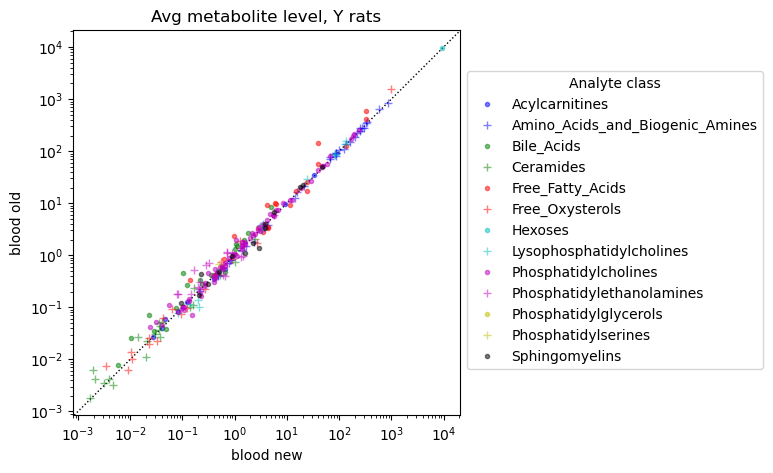

In [4]:
def take1avg(metabolite, group, dataset, data=data):
    df = data[dataset]
    res = df.loc[df.Group == group, metabolite].mean()
    return(res)

def take_all_avgs(group, dataset, data=data):
    l = [take1avg(metabolite, group, dataset, data=data) for metabolite in data[dataset].columns[2:]]
    s = pd.Series(l, index=data[dataset].columns[2:])
    return(s)

def avg_metab_scatter(group, datasetA, datasetB, data=data):
    l = [take_all_avgs(group, dataset, data=data) for dataset in [datasetA, datasetB]]
    df = pd.concat(l, axis=1, join='inner')
    df.columns = [datasetA, datasetB]
    return(df)

def avg_metab_scatter_plot(group, datasetA, datasetB, data=data, codebookpath=codebookpath):
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    df = avg_metab_scatter(group, datasetA, datasetB, data=data)
    df = pd.concat([df, codebook.AnalyteClass], axis=1)
    fig, ax = plt.subplots(figsize=(5, 5))
    my_cycler = (cycler(color=list('bgrcmyk')) * cycler(marker=['.', '+']))
    ax.set_prop_cycle(my_cycler)
    ax.set_xlabel(datasetA)
    ax.set_ylabel(datasetB)
    ax.set_title('Avg metabolite level, ' + group + ' rats')
    ax.axline((0, 0), slope=1, linewidth=1, linestyle='dotted', color='black')
    for aclass in np.unique(df.AnalyteClass):
        clsdata = df.loc[df.AnalyteClass == aclass]
        ax.plot(clsdata[datasetA], clsdata[datasetB], label=aclass, alpha=0.5, linestyle = '')
        #ax.scatter(x=datasetA, y=datasetB, data=clsdata, label=aclass)
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Analyte class')
    return((fig, ax))


fig, ax = avg_metab_scatter_plot('Y', 'blood new', 'blood old')

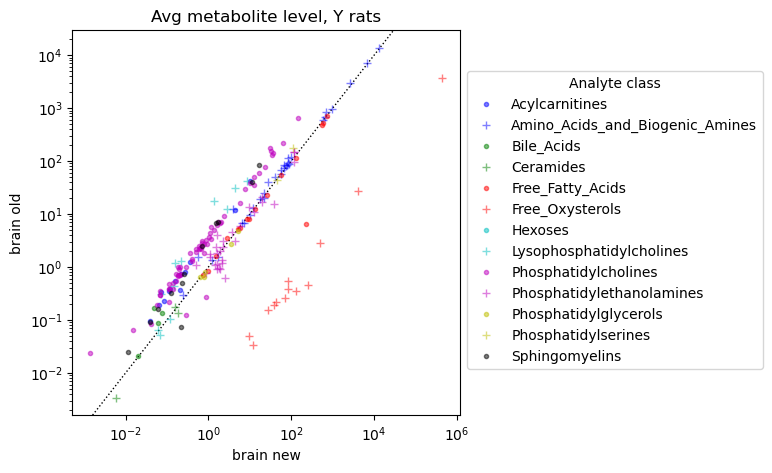

In [5]:
fig, ax = avg_metab_scatter_plot('Y', 'brain new', 'brain old')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'avg-metab-brain-vs-brain-old-Y')

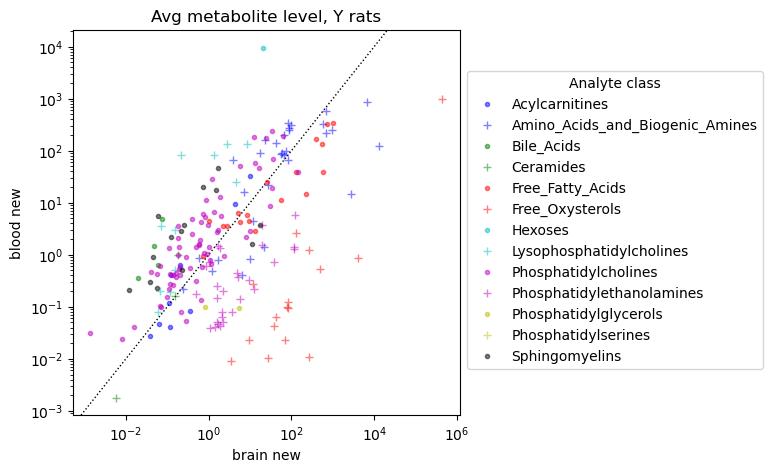

In [6]:
fig, ax = avg_metab_scatter_plot('Y', 'brain new', 'blood new')

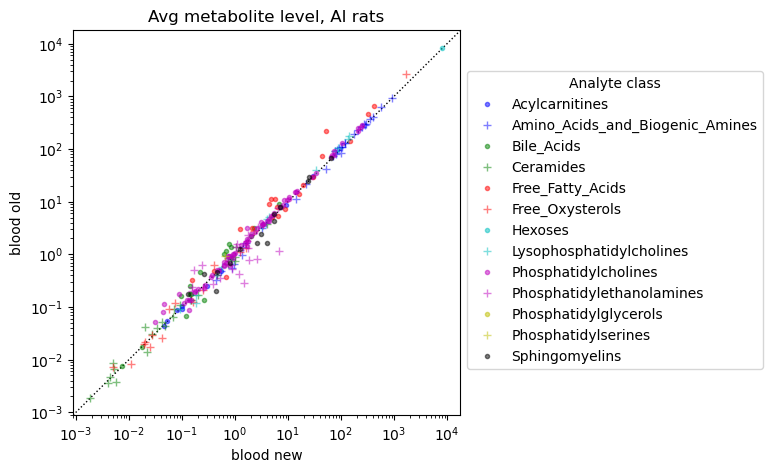

In [7]:
fig, ax = avg_metab_scatter_plot('AI', 'blood new', 'blood old')

## Statistical comparison of AI, AU, Y groups

We apply the two sample t-test for each null hypotheses of no change in a given methabolite's level in condition A relative to that in condition B.  Before we write the complete set of resuls into `summary.csv`, we perform FDR control at various $\alpha$s using the Benjamini-Hochberg procedure.  The bonferroni corrected $\alpha$ values are also calculated.

In [8]:
def extract2groups(metabolite, groupA='AU', groupB='AI', df=data['blood new']):
    l = [df.loc[df.Group == g, metabolite].dropna() for g in [groupA, groupB]]
    return(l)

def get_log_p(A, B):
    val = - np.log10(stats.ttest_ind(A, B)[1])
    return(val)

def get_effect_size(A, B):
    '''
    The effect size x is B relative to A, so if A > B => x < 0
    '''
    #val = B.mean() - A.mean() # the original definition; does not normalize effect size!
    OR = B.mean() / A.mean()
    log2OR = np.log2(OR)
    return(log2OR)

def get_both(metabolite, groupA='AU', groupB='AI', df=data['blood new']):
    A, B = extract2groups(metabolite, groupA, groupB, df)
    log_p = get_log_p(A, B)
    fx_size = get_effect_size(A, B)
    return((fx_size, log_p))

def get_both_all(groupA='AU', groupB='AI', df=data['blood new']):
     metabolites = df.columns[2:]
     l = [get_both(m, groupA, groupB, df) for m in metabolites]
     fx_sizes = [x[0] for x in l]
     log_ps = [x[1] for x in l]
     return((fx_sizes, log_ps))

In [9]:
comparisons = {
    'AI vs. AU': ['AU', 'AI'],
    'AI vs. Y': ['Y', 'AI'],
    'AU vs. Y': ['Y', 'AU'],
              }
results = {d: {k: get_both_all(*v, df=data[d]) for k, v in comparisons.items()} for d in data.keys()}

In [10]:
def writeResults(dataset='brain new', comparison='AI vs. AU', alpha=0.05, method='fdr_bh', data=data, results=results):
    dat = data[dataset]
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    metabolites = dat.columns[2:]
    metab_class = codebook.loc[metabolites, 'AnalyteClass']
    res = results[dataset]
    t = res[comparison]
    direction = ['Increase' if x>0 else 'Decrease' for x in t[0]]
    pvals = 10 ** (-np.array(t[1]))
    reject, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(pvals, alpha=alpha, method=method)
    df = pd.DataFrame({'Dataset':dataset, 'Comparison': comparison,
                       'Analyte class': metab_class, 'Metabolite': metabolites,
                       'Effect size':t[0],'"- log p"':t[1], 'p': pvals,
                       r'Corrected p': pvals_corrected,
                       r'Reject H0': reject,
                       r'Bonferroni alpha': alphacBonf,
                       'Direction of change': direction})
    df = df.sort_values('Effect size')
    df = df.sort_values('p')
    df['Rank'] = np.arange(len(df)) + 1
    return(df)

In [11]:
def get_summary(data, results, liberal_only=False):
    def helper(df, dataset, liberal_only=liberal_only):
        if not liberal_only:
            return(df)
        rows = set(excluded_metabolites_cons[dataset]).difference(set(excluded_metabolites[dataset]))
        return(df.loc[rows])
    ll = [[helper(writeResults(dataset=d, comparison=c), d, liberal_only) for c in comparisons.keys()] for d in data.keys()]
    #ll = [[writeResults(dataset=d, comparison=c) for c in comparisons.keys()] for d in data.keys()]
    l = itertools.chain(*ll)
    summary = pd.concat(l)
    return(summary)

summary = get_summary(data=data, results=results)
summary_lib_only = get_summary(data=data, results=results, liberal_only=True)

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_11408/2062942235.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return(df.loc[rows])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_11408/2062942235.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return(df.loc[rows])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_11408/2062942235.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return(df.loc[rows])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_11408/2062942235.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return(df.loc[rows])
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_11408/2062942235.py:6: FutureWarning: Passing a set as an indexer is 

### Adding subclassification of bile acids and oxysterols

In [12]:
subclassification = ratmetab.read_subclassification()
subclassification

,Analyte class,Subclass
Metabolite,,
Deoxycholic acid,Bile_Acids,Bile_Acids_Secondary
Taurodeoxycholic acid,Bile_Acids,Bile_Acids_Secondary
Lithocholic acid,Bile_Acids,Bile_Acids_Secondary
omega-Muricholic acid,Bile_Acids,Bile_Acids_Primary
Tauromuricholic acid (alpha + beta),Bile_Acids,Bile_Acids_Primary
Tauroursodeoxycholic acid,Bile_Acids,Bile_Acids_Secondary
Taurocholic acid,Bile_Acids,Bile_Acids_Primary
Glycoursodeoxycholic acid,Bile_Acids,Bile_Acids_Secondary
Taurolithocholic acid,Bile_Acids,Bile_Acids_Primary


In [13]:
ratmetab.add_subclassification_to_df(summary, subclassification)

if os.getlogin() == 'jonesa7':
    summary.to_csv('../../results/2022-11-09-rat-metabolites/summary.csv')
summary

,Dataset,Comparison,Analyte class,Metabolite,Effect size,"""- log p""",p,Corrected p,Reject H0,Bonferroni alpha,Direction of change,Rank,Subclass
Phosphatidylcholine aa C40:5,blood new,AI vs. AU,Phosphatidylcholines,Phosphatidylcholine aa C40:5,-0.656900,1.831301,0.014747,0.769241,False,0.000174,Decrease,1,Phosphatidylcholines
Linolenic acid,blood new,AI vs. AU,Free_Fatty_Acids,Linolenic acid,-0.442021,1.707973,0.019590,0.769241,False,0.000174,Decrease,2,Free_Fatty_Acids
"5-beta,6-beta-Epoxycholesterol",blood new,AI vs. AU,Free_Oxysterols,"5-beta,6-beta-Epoxycholesterol",-1.162864,1.677275,0.021024,0.769241,False,0.000174,Decrease,3,Free_Oxysterols_Non_Enzymatic
Spermine,blood new,AI vs. AU,Amino_Acids_and_Biogenic_Amines,Spermine,0.550324,1.646695,0.022558,0.769241,False,0.000174,Increase,4,Amino_Acids_and_Biogenic_Amines
trans-4-Hydroxyproline,blood new,AI vs. AU,Amino_Acids_and_Biogenic_Amines,trans-4-Hydroxyproline,0.969954,1.588279,0.025806,0.769241,False,0.000174,Increase,5,Amino_Acids_and_Biogenic_Amines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Phosphatidylcholine ae C36:4,brain,AU vs. Y,Phosphatidylcholines,Phosphatidylcholine ae C36:4,0.007427,0.010128,0.976949,0.988861,False,0.000198,Increase,248,Phosphatidylcholines
Docosapentaenoic acid (DPA),brain,AU vs. Y,Free_Fatty_Acids,Docosapentaenoic acid (DPA),-0.012469,0.009134,0.979188,0.988861,False,0.000198,Decrease,249,Free_Fatty_Acids
Leucine,brain,AU vs. Y,Amino_Acids_and_Biogenic_Amines,Leucine,-0.002016,0.008325,0.981013,0.988861,False,0.000198,Decrease,250,Amino_Acids_and_Biogenic_Amines
Sphingomyelin C18:0,brain,AU vs. Y,Sphingomyelins,Sphingomyelin C18:0,-0.001245,0.001622,0.996273,0.997424,False,0.000198,Decrease,251,Sphingomyelins


In [14]:
sel_classes = ['Bile_Acids', 'Free_Oxysterols']

def restrict_summary(sel_classes, dataset='blood', comparison='AI vs. AU', alpha=0.2, method='fdr_bh', summary=summary):
    df = summary.loc[(summary.Dataset == dataset) & (summary.Comparison == comparison) & (summary['Analyte class'].isin(sel_classes))].copy()
    pvals = df.p
    reject, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(pvals, alpha=alpha, method=method)
    df[r'Reject H0'] = reject
    df[r'Corrected p'] = pvals_corrected
    df[r'Bonferroni alpha'] = alphacBonf
    df = df.sort_values('Effect size')
    df = df.sort_values('p')
    df['Rank'] = np.arange(len(df)) + 1
    return(df)


def restrict_rerank(sel_classes, dataset='blood', comparison='AI vs. AU', alpha=0.2, method='fdr_bh', summary=summary, refcomparison='AI vs. AU'):
    refdf = restrict_summary(sel_classes, dataset, refcomparison, alpha, method, summary)
    df = restrict_summary(sel_classes, dataset, comparison, alpha, method, summary)
    df = df.reindex_like(refdf)
    df.loc[:, 'Rank'] = np.arange(len(df)) + 1
    return(df)

summary_bileoxy = restrict_summary(sel_classes)
summary_bileoxy3 = pd.concat([restrict_rerank(sel_classes, comparison=c) for c in ['AI vs. AU', 'AU vs. Y', 'AI vs. Y']], axis=0)
if os.getlogin() == 'jonesa7':
    summary_bileoxy.to_csv('../../results/2022-11-09-rat-metabolites/summary_bileoxy.csv')
    summary_bileoxy3.to_csv('../../results/2022-11-09-rat-metabolites/summary_bileoxy3.csv')
summary_bileoxy3

,Dataset,Comparison,Analyte class,Metabolite,Effect size,"""- log p""",p,Corrected p,Reject H0,Bonferroni alpha,Direction of change,Rank,Subclass
"24,25-Epoxycholesterol",blood,AI vs. AU,Free_Oxysterols,"24,25-Epoxycholesterol",-0.572762,2.867472,0.001357,0.044151,True,0.005405,Decrease,1,Free_Oxysterols_Enzymatic
"24,25-Dihydrolanosterol",blood,AI vs. AU,Free_Oxysterols,"24,25-Dihydrolanosterol",-0.672445,2.622229,0.002387,0.044151,True,0.005405,Decrease,2,Free_Oxysterols_Enzymatic
Desmosterol,blood,AI vs. AU,Free_Oxysterols,Desmosterol,-0.333495,2.319631,0.004790,0.059081,True,0.005405,Decrease,3,Free_Oxysterols_Enzymatic
"5-beta,6-beta-Epoxycholesterol",blood,AI vs. AU,Free_Oxysterols,"5-beta,6-beta-Epoxycholesterol",-0.754669,2.167164,0.006805,0.062947,True,0.005405,Decrease,4,Free_Oxysterols_Non_Enzymatic
7-alpha-Hydroxycholesterol,blood,AI vs. AU,Free_Oxysterols,7-alpha-Hydroxycholesterol,-0.589904,1.611568,0.024459,0.154586,True,0.005405,Decrease,5,Free_Oxysterols_Enzymatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27-Hydroxycholesterol,blood,AI vs. Y,Free_Oxysterols,27-Hydroxycholesterol,0.972704,4.504466,0.000031,0.000400,True,0.005405,Increase,33,Free_Oxysterols_Enzymatic
Taurochenodeoxycholic acid,blood,AI vs. Y,Bile_Acids,Taurochenodeoxycholic acid,1.287523,1.661250,0.021815,0.057653,True,0.005405,Increase,34,Bile_Acids_Primary
"5-alpha,6-beta-Dihydroxycholestanol (THC)",blood,AI vs. Y,Free_Oxysterols,"5-alpha,6-beta-Dihydroxycholestanol (THC)",0.656132,5.530318,0.000003,0.000109,True,0.005405,Increase,35,Free_Oxysterols_Non_Enzymatic
Hyodeoxycholic acid,blood,AI vs. Y,Bile_Acids,Hyodeoxycholic acid,-0.673565,1.082916,0.082620,0.152847,True,0.005405,Decrease,36,Bile_Acids_Secondary


## Volcano plots

These plots show that AU and AI are more similar to each other than either of them to Y.  Another finding is that metabolites in the same predefined metabolite group are clustered together, which confirms biological signals in the possibly qiute noisy data.

In [15]:
def volcano_subplot(axi, df, comparison, dataset, classes, dolabel=False, class_column='Analyte class', topk=None):
    my_cycler = (cycler(color=list('bgrcmyk')) * cycler(marker=['.', '+']))
    axi.set_prop_cycle(my_cycler)
    bonf_alpha = -np.log10(df['Bonferroni alpha'].to_list()[0])
    axi.axhline(y=bonf_alpha, linestyle='dotted', color='black', linewidth=1)
    for k, cls in enumerate(classes):
        clsdf = df.loc[(df[class_column] == cls) & (df.Dataset == dataset)]
        label = cls if dolabel else None
        axi.plot(clsdf['Effect size'], clsdf['"- log p"'], label=label, alpha=0.5, linestyle = '')
        if topk is not None:
            clsdf_top = clsdf.loc[clsdf.Rank <= topk]
            for x, y, r in zip(clsdf_top['Effect size'], clsdf_top['"- log p"'], clsdf_top.Rank):
                axi.text(x, y, str(r), horizontalalignment='center', verticalalignment='bottom')
        #axi.scatter(x=clsdf['Effect size'], y=clsdf['"- log p"'], label=cls, alpha=0.5) # this does not work with cycler & marker 
        axi.set_title(comparison, fontsize=14)
        axi.set_ylabel(dataset, fontsize=14)
    return(axi)

def my_volcano(summary, swapij=False, figsize=(15, 20), class_column='Analyte class', topk=None, do_legend=True, comparisons=None):
    comparisons = np.unique(summary.Comparison) if comparisons is None else comparisons
    datasets = np.unique(summary.Dataset)
    classes = np.unique(summary[class_column])
    fig, ax = plt.subplots(len(datasets), len(comparisons), figsize=figsize, sharey=True, sharex=True, squeeze=False)
    for i, dataset in enumerate(datasets):
        for j, comparison in enumerate(comparisons):
            df = summary.loc[(summary.Dataset == dataset) & (summary.Comparison == comparison)]
            axi = ax[j, i] if swapij else ax[i, j]
            dolabel = (i == 0) and (j == 0)
            volcano_subplot(axi, df, comparison, dataset, classes, dolabel=dolabel, class_column=class_column, topk=topk)
    fig.supxlabel(r'$\log_{2}$ fold change', fontsize=16)
    fig.supylabel(r'$- \log_{10} p$', fontsize=16)
    if do_legend:
        fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), title='Analyte class')
    return((fig, ax))

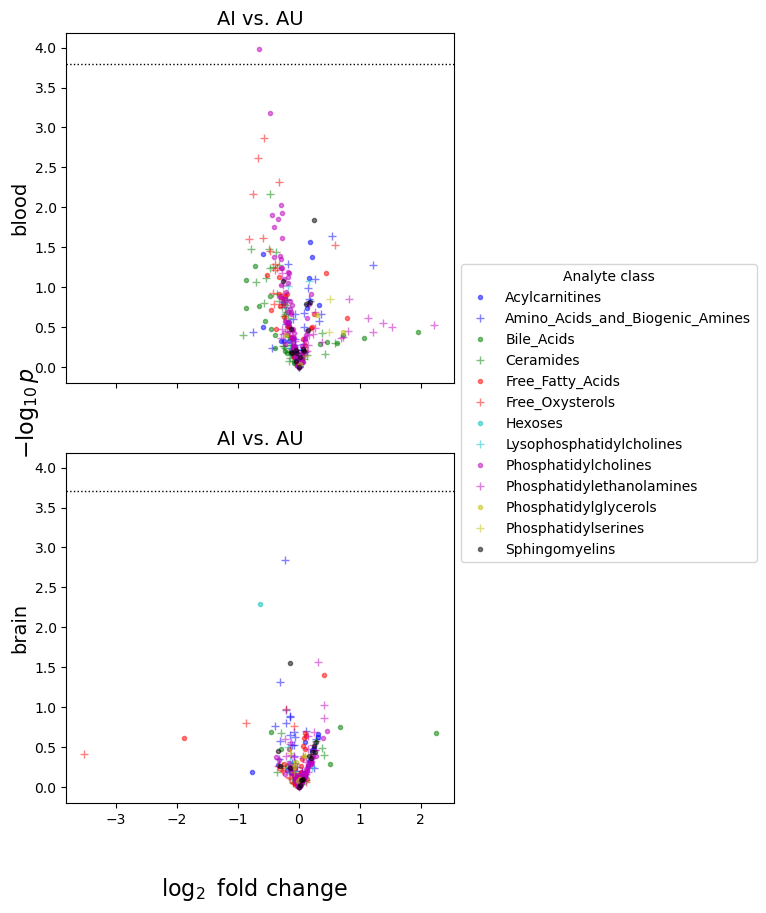

In [16]:
fig, ax = my_volcano(summary.loc[(summary.Comparison == 'AI vs. AU') & summary.Dataset.isin(['blood', 'brain'])], figsize=(5, 10))
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots-aged')

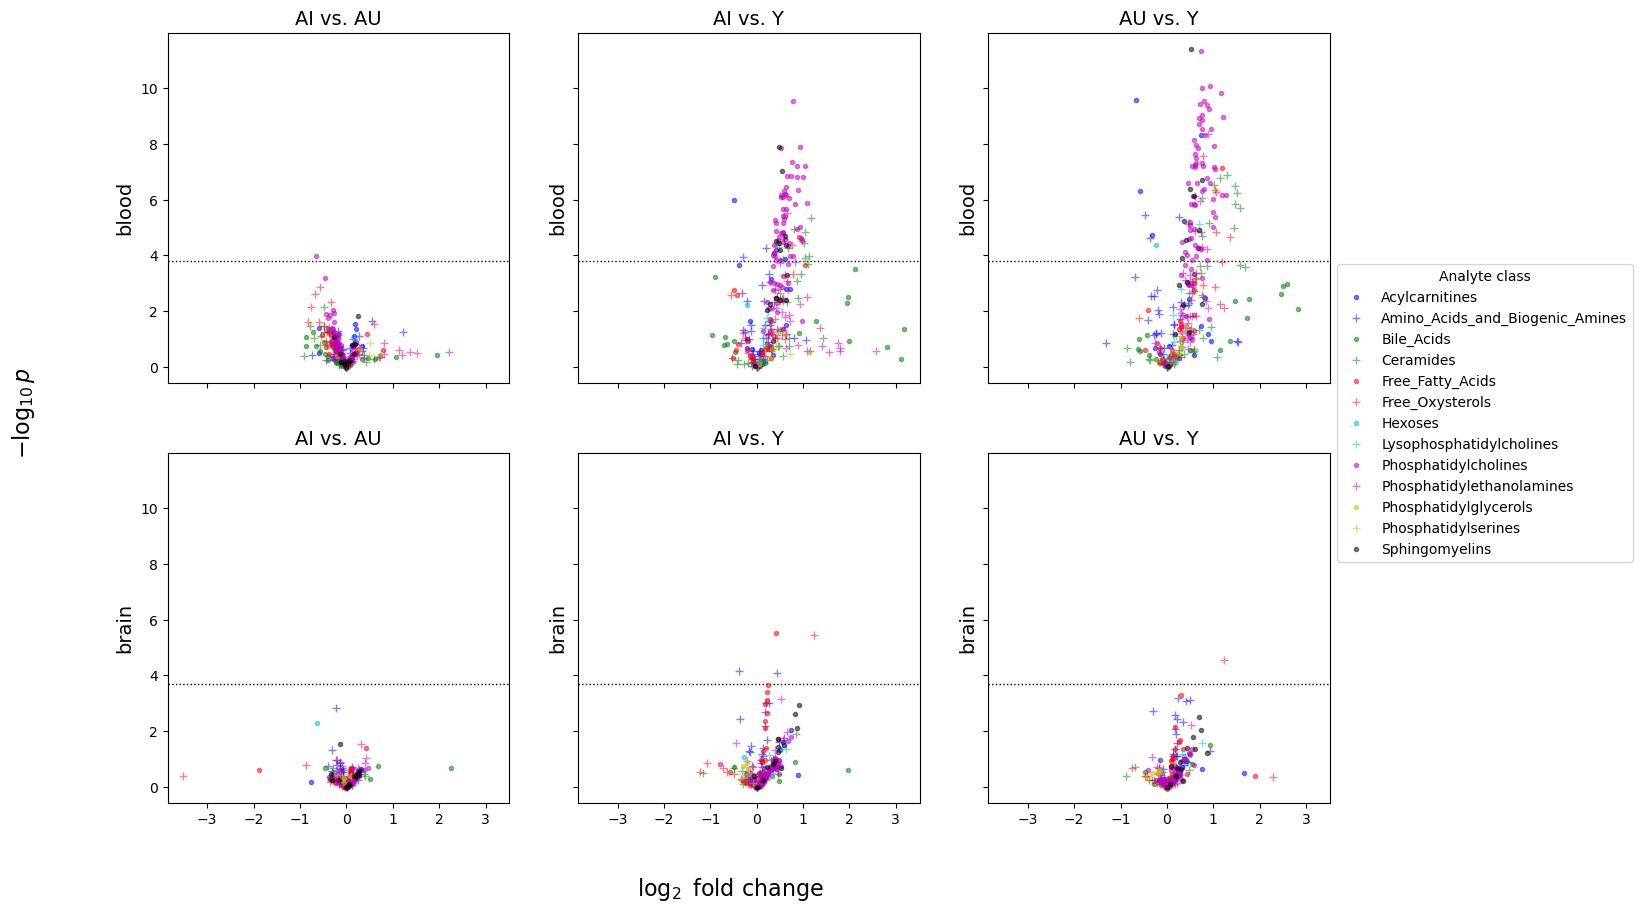

In [17]:
fig, ax = my_volcano(summary.loc[summary.Dataset.isin(['blood', 'brain'])], figsize=(15, 10))
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots')

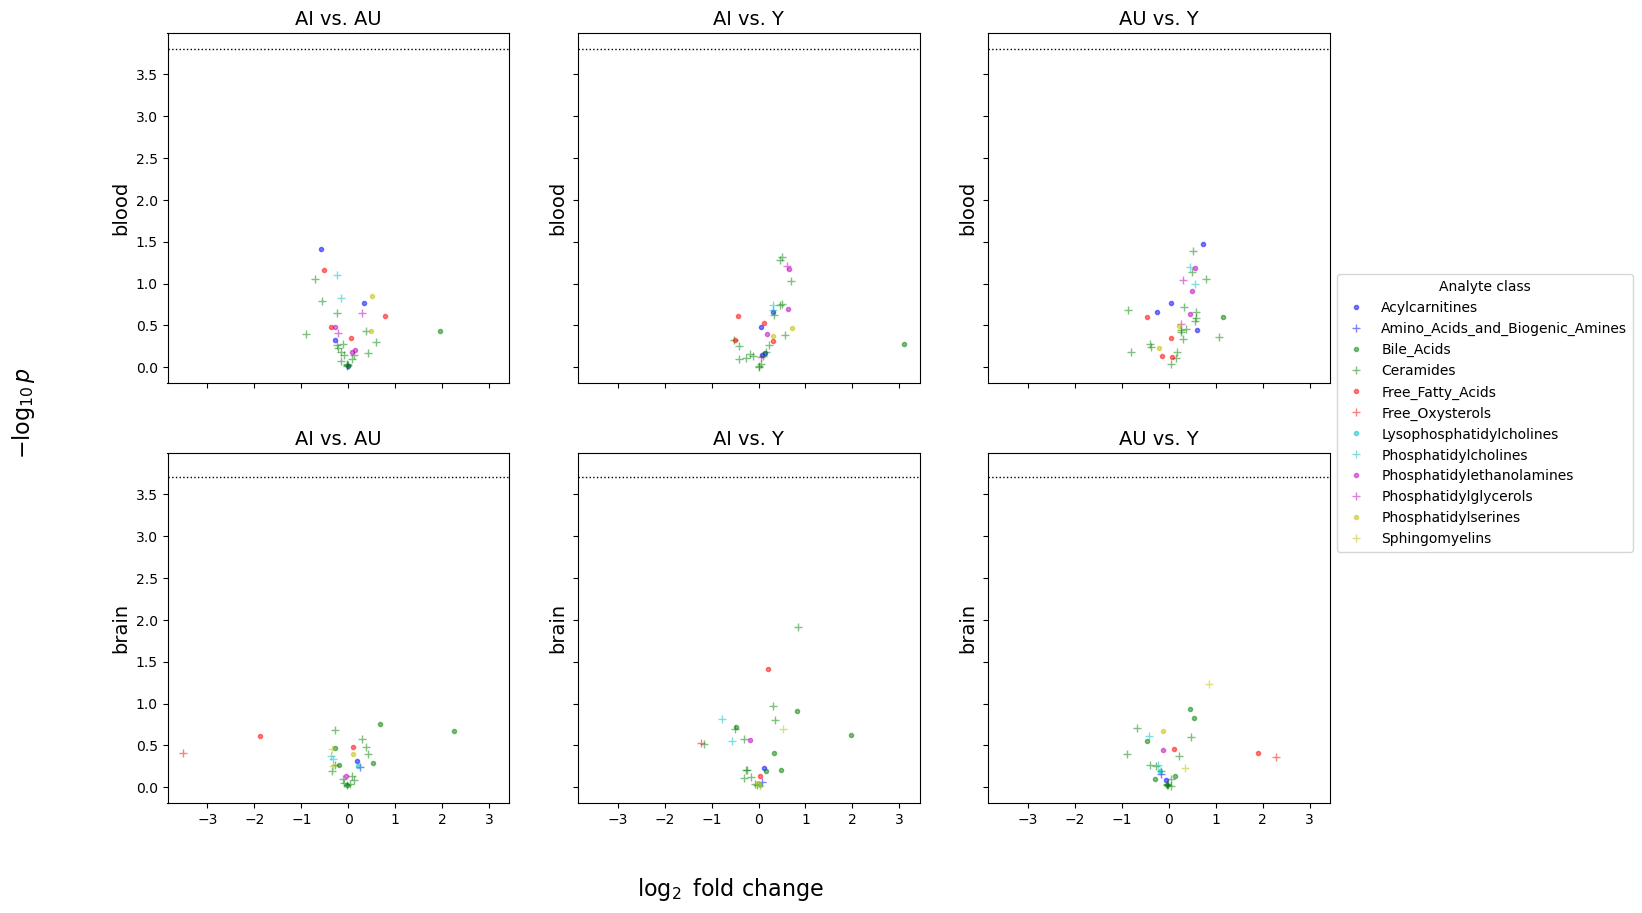

In [18]:
fig, ax = my_volcano(summary_lib_only.loc[summary_lib_only.Dataset.isin(['blood', 'brain'])], figsize=(15, 10))
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots-aged_lib_only')

Below only those metabolites are plotted that we gained by replacing the more conservative filter 2 with the more liberal filter 1.

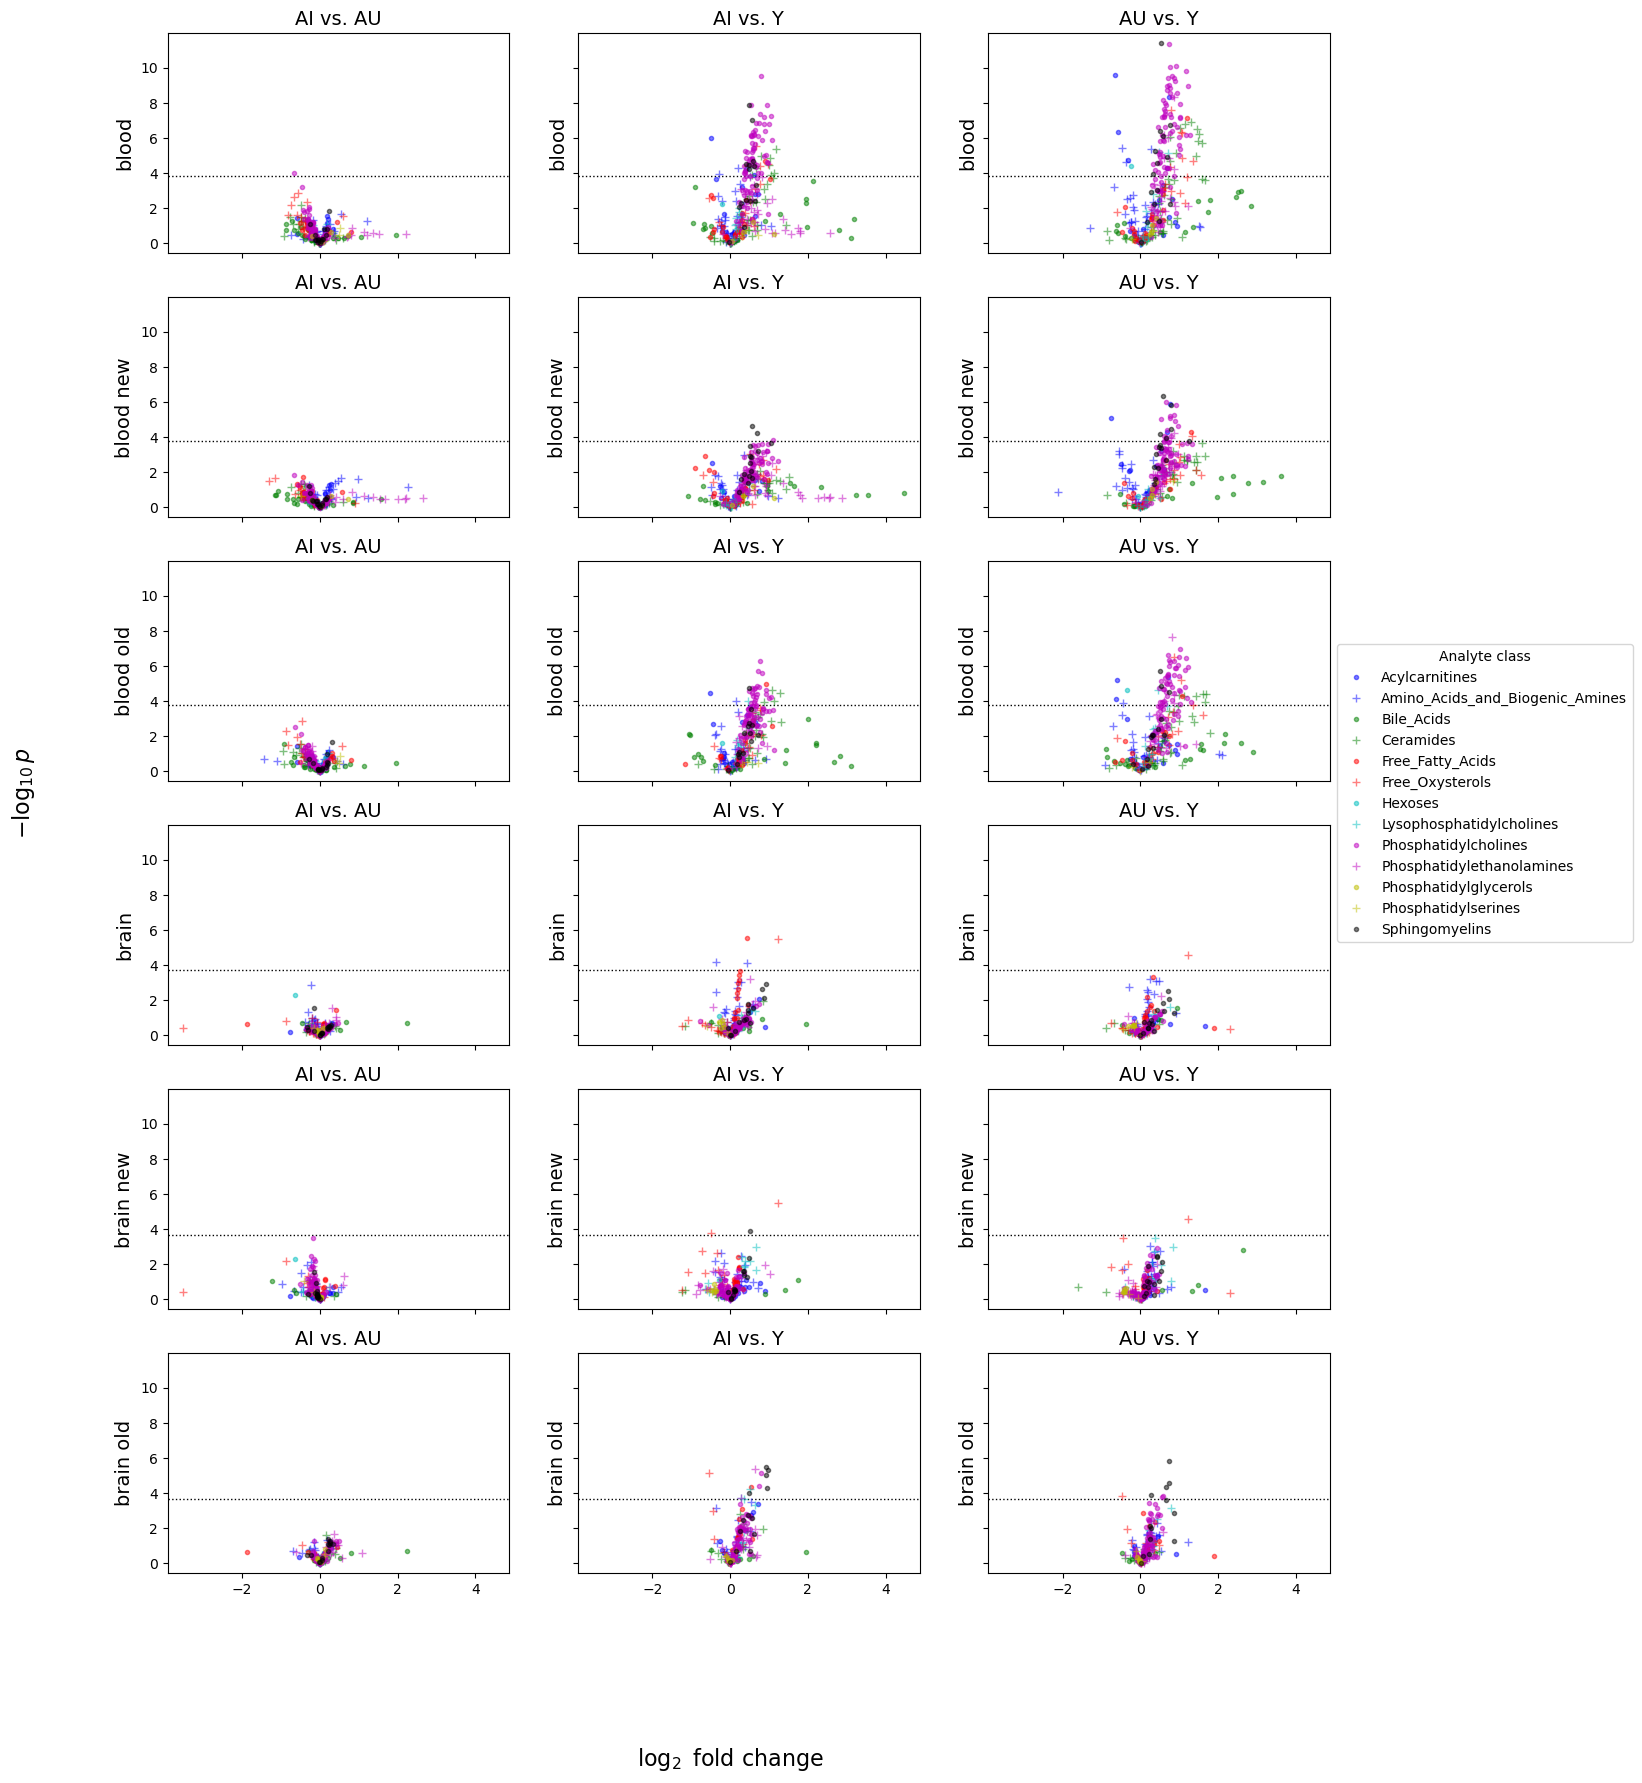

In [19]:
fig, ax = my_volcano(summary)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots')

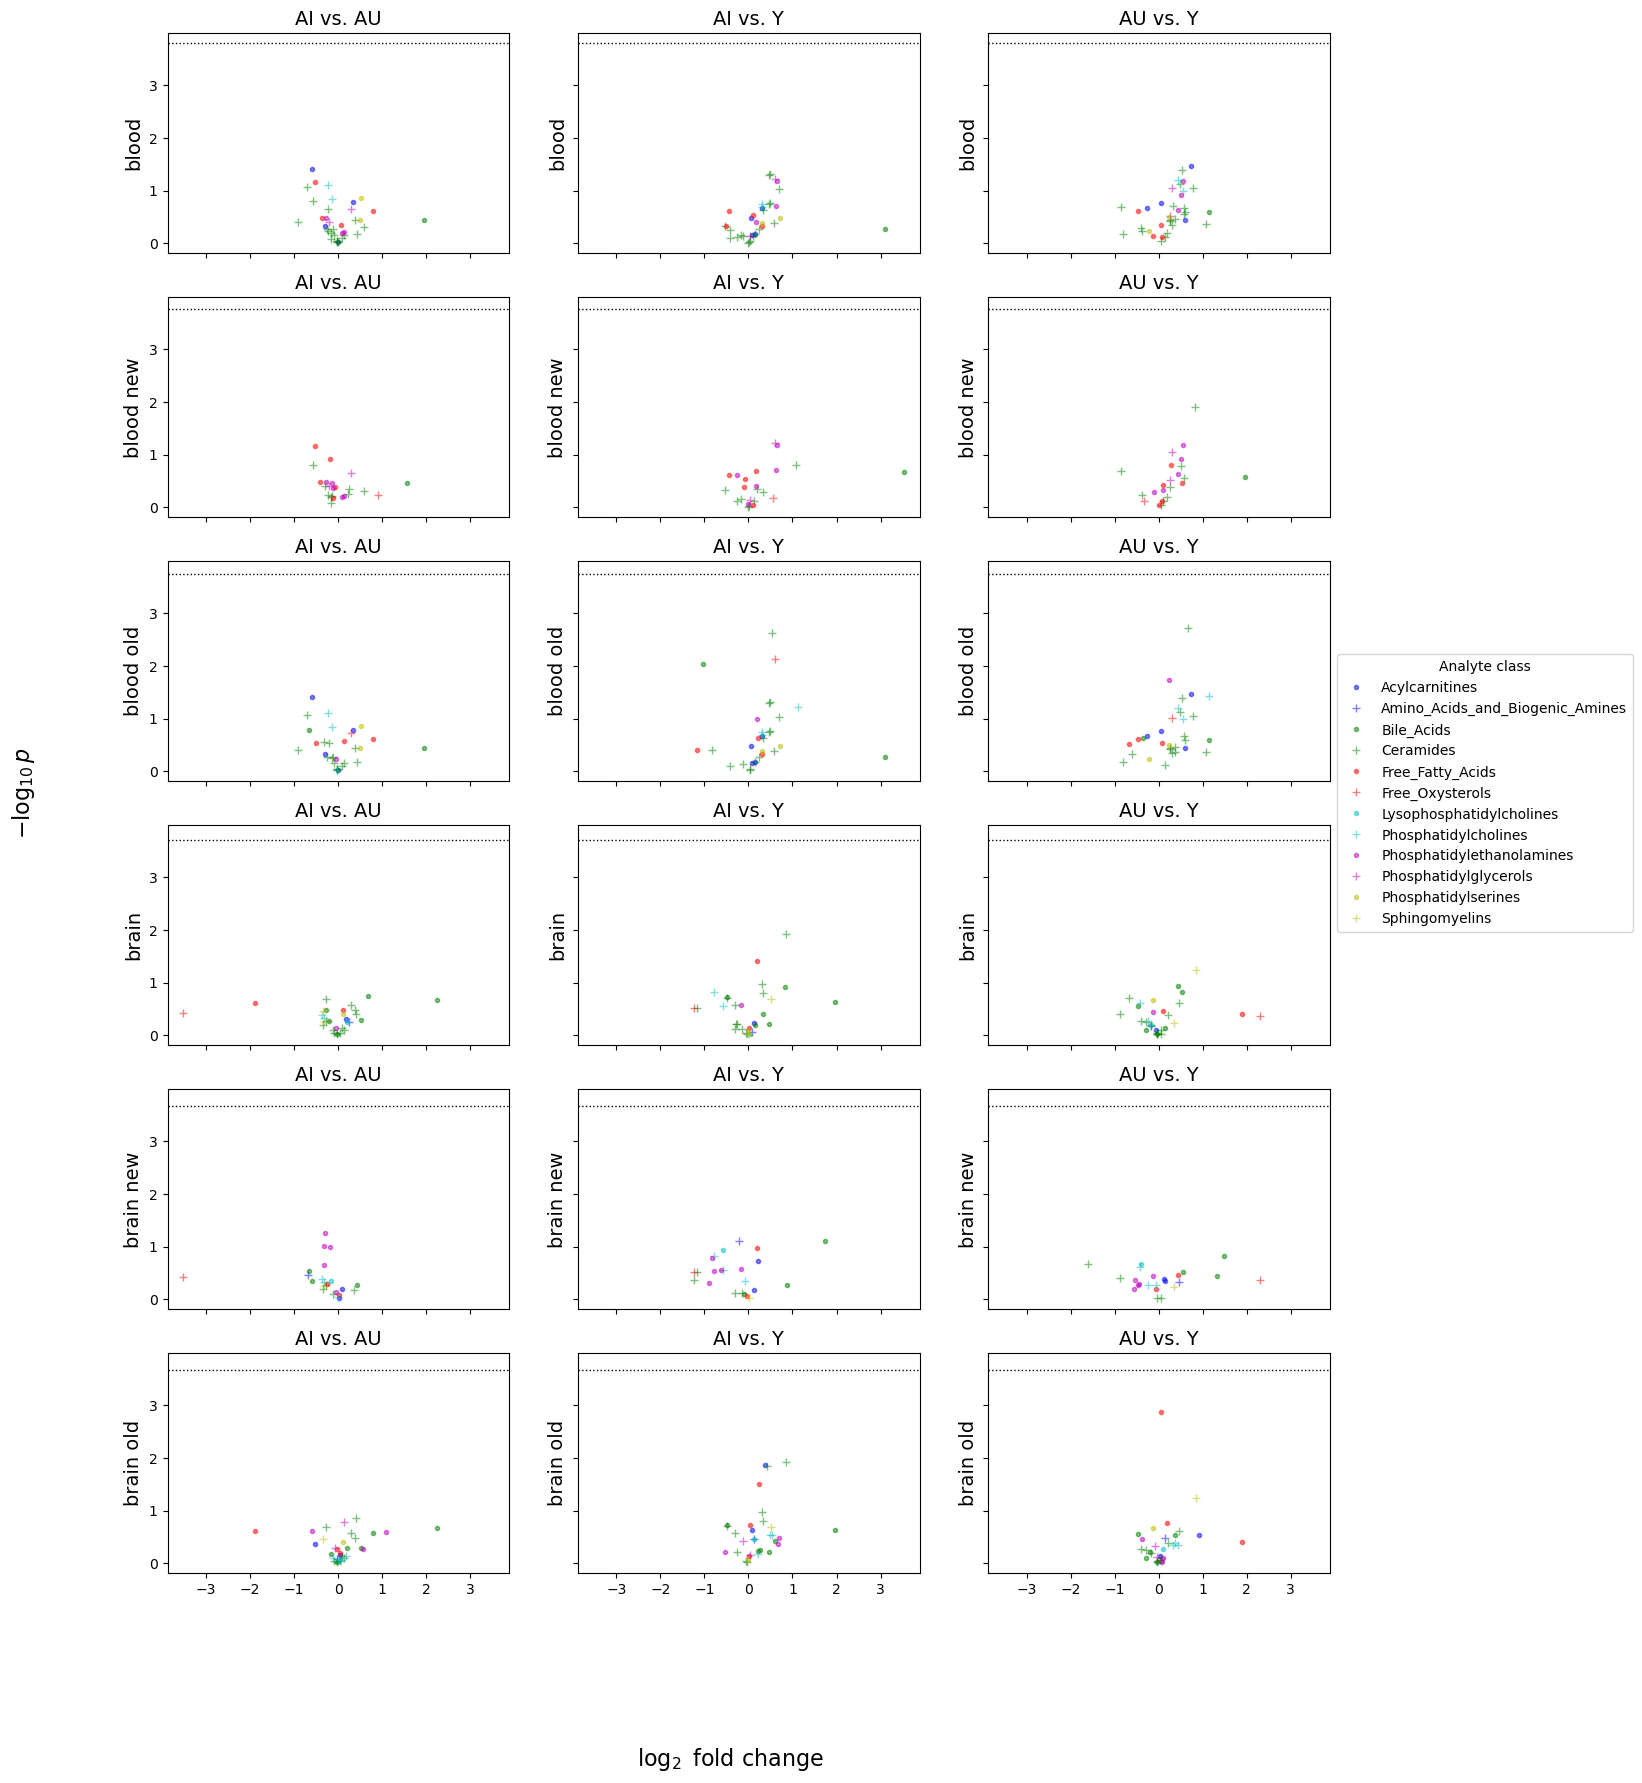

In [20]:
fig, ax = my_volcano(summary_lib_only)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots_lib_only')

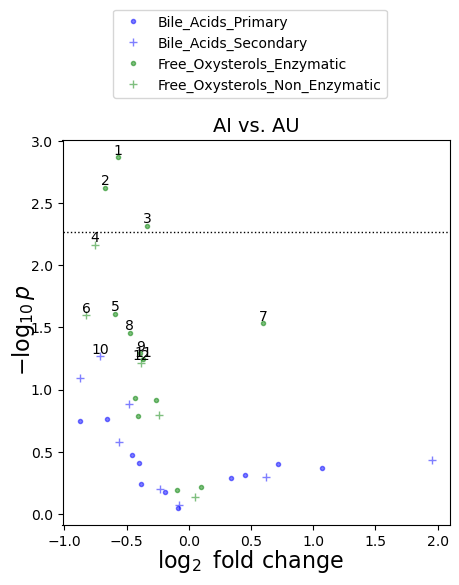

In [21]:
fig, ax = my_volcano(summary_bileoxy, figsize=(5, 5), class_column='Subclass', topk=12, do_legend=False)
ax[0][0].set_ylabel('')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.95))
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots-aged-oxybile')

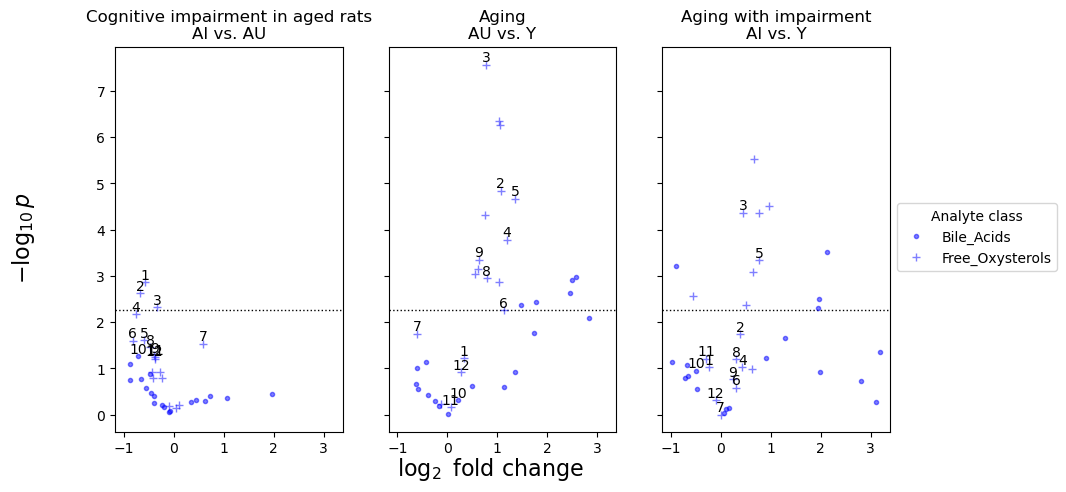

In [22]:
comparisons = ['AI vs. AU', 'AU vs. Y', 'AI vs. Y']
interpretations = ['Cognitive impairment in aged rats', 'Aging', 'Aging with impairment']
fig, ax = my_volcano(summary_bileoxy3, figsize=(10, 5), topk=12, comparisons=comparisons)

for axi, comp, interpret in zip(ax[0], comparisons, interpretations):
    axi.set_ylabel('')
    axi.set_title(interpret + '\n' + comp)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots-oxybile-3')

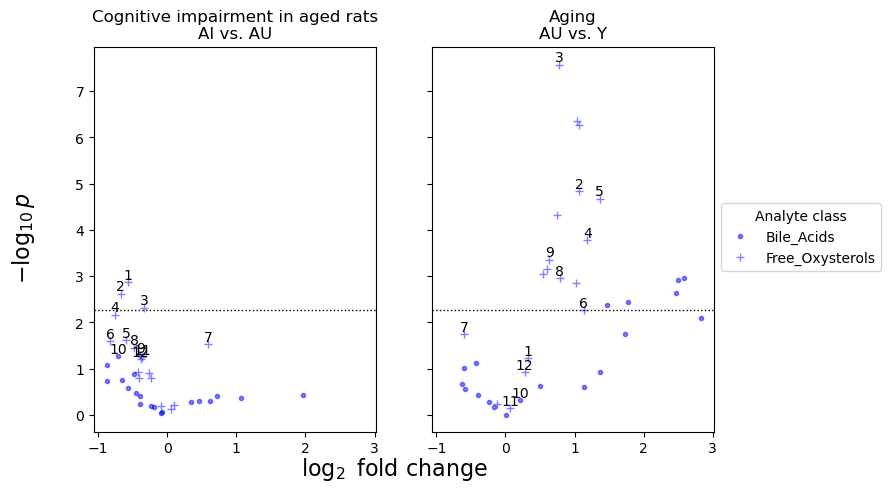

In [23]:
fig, ax = my_volcano(summary_bileoxy3.loc[summary_bileoxy3.Comparison != 'AI vs. Y'], figsize=(8, 5), topk=12)
for axi, comp, interpret in zip(ax[0], comparisons, interpretations):
    axi.set_ylabel('')
    axi.set_title(interpret + '\n' + comp)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'volcano-plots-oxybile-3-2panel')

### Violin plots

In [24]:
def fx_size_violin(comparison='AI vs. AU', dataset='blood', summary=summary, classification='Analyte class'):
    fig, ax = plt.subplots(figsize=(9, 6))
    d = summary.loc[(summary.Dataset == dataset) & (summary.Comparison == comparison)].sort_values(classification, ascending=False)
    ax = sns.violinplot(y=classification, x='Effect size', data=d, ax=ax, width=1.25, inner='point')
    ax.set_xlabel(r'$\log_{2}$ fold change')
    ax.set_title(comparison + ' comparison in ' + dataset)
    #ax.set_title('Uncorrected effect size distributions')
    ax.grid(axis='x')
    ax.set_xlim(-1.25, 1.25)
    return((fig, ax))

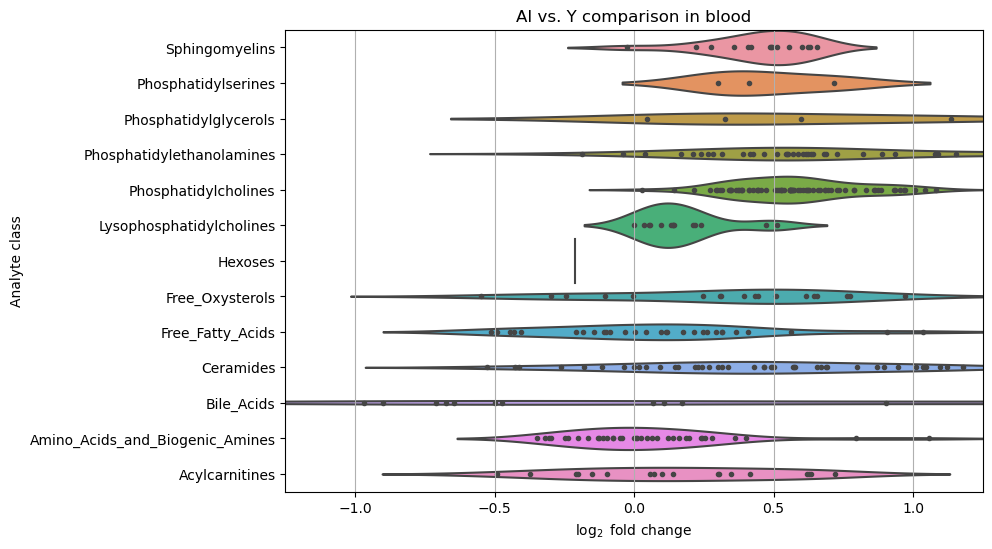

In [25]:
fig, ax = fx_size_violin(comparison='AI vs. Y', dataset='blood')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'effect_size-violinplot-blood-AI_vs_Y')

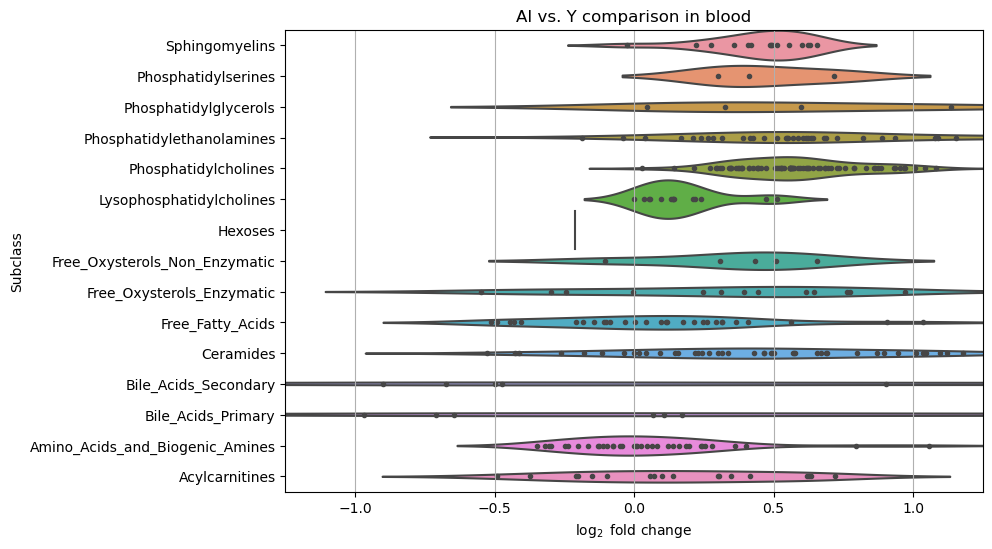

In [26]:
fig, ax = fx_size_violin(comparison='AI vs. Y', dataset='blood', classification='Subclass')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'effect_size-violinplot-blood-AI_vs_Y-subclass')

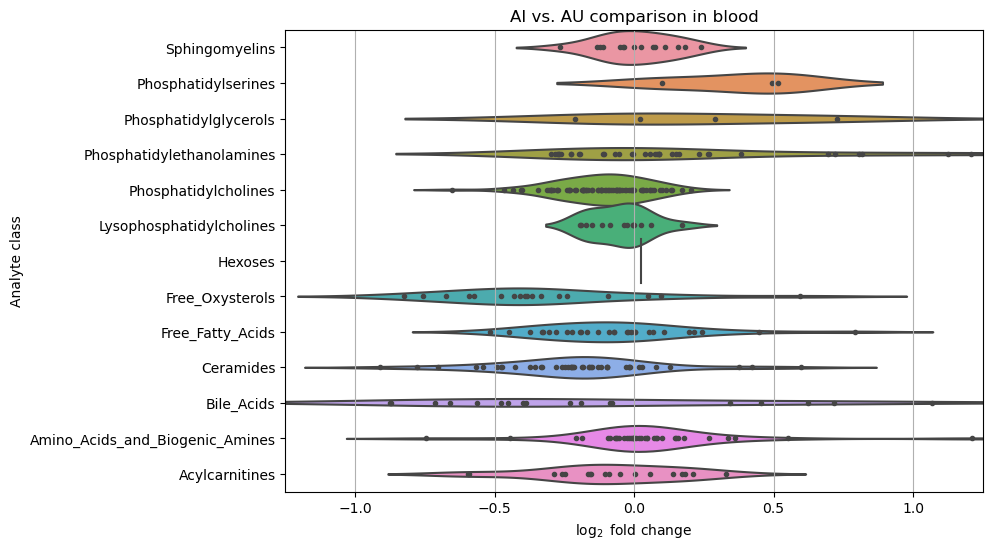

In [27]:
fig, ax = fx_size_violin(comparison='AI vs. AU', dataset='blood')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'effect_size-violinplot-blood-AI_vs_AU')

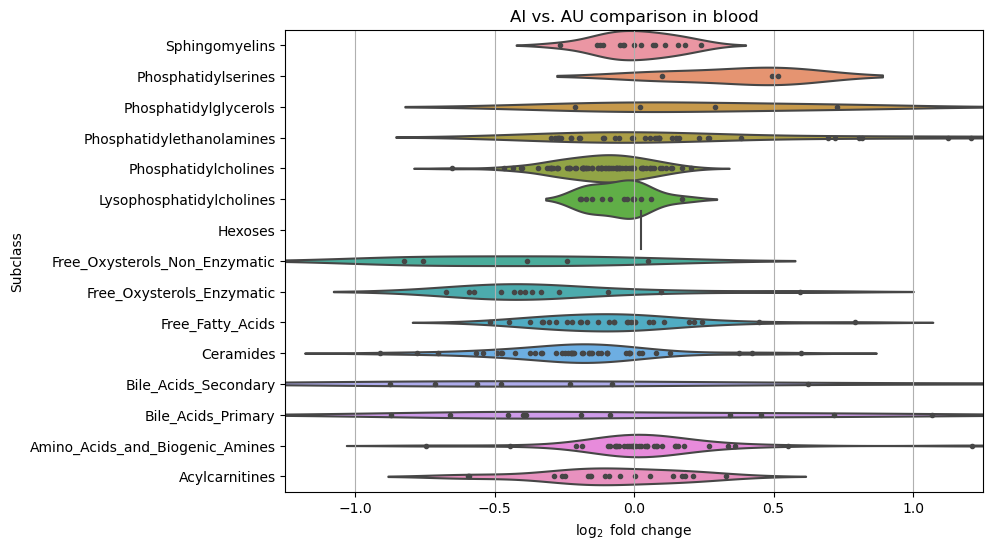

In [28]:
fig, ax = fx_size_violin(comparison='AI vs. AU', dataset='blood', classification='Subclass')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'effect_size-violinplot-blood-AI_vs_AU-subclass')

## Comparing data sets

These plots investigate how well findings replicate from the old to the present data sets or how metabolic changes differ in blood vs brain.

In [29]:
def dataset_scatter(datasetA, datasetB, comparison, ax, statistic='"- log p"', summary=summary, rank_thrs=20):
    A, B = [summary.loc[(summary.Dataset == d) & (summary.Comparison == comparison), [statistic, 'Rank']] for d in [datasetA, datasetB]]
    df = pd.concat([A, B], axis=1, join='inner')
    df.columns = [datasetA, 'Rank ' + datasetA, datasetB, 'Rank ' + datasetB]
    df['color'] = None
    df.loc[(df['Rank ' + datasetA] <= rank_thrs) & (df['Rank ' + datasetB] <= rank_thrs), 'color'] = 'orange'
    df.loc[(df['Rank ' + datasetA] <= rank_thrs) & (df['Rank ' + datasetB] > rank_thrs), 'color'] = 'magenta'
    df.loc[(df['Rank ' + datasetA] > rank_thrs) & (df['Rank ' + datasetB] <= rank_thrs), 'color'] = 'blue'
    df.loc[(df['Rank ' + datasetA] > rank_thrs) & (df['Rank ' + datasetB] > rank_thrs), 'color'] = 'lightgray'
    #return((thrsA, thrsB))
    ax.scatter(x=datasetA, y=datasetB, data=df, marker='.', color=df.color)
    color = 'black'
    linestyle = 'dotted'
    linewidth = 1
    if statistic == '"- log p"':
        ax.axvline(df.loc[df['Rank ' + datasetA] == rank_thrs, datasetA].to_list()[0], color=color, linestyle=linestyle, linewidth=linewidth)
        ax.axhline(df.loc[df['Rank ' + datasetB] == rank_thrs, datasetB].to_list()[0], color=color, linestyle=linestyle, linewidth=linewidth)
    if statistic == 'Effect size':
        ax.axline((0, 0), slope=1, color=color, linestyle=linestyle, linewidth=linewidth)
    ax.set_xlabel(datasetA)
    ax.set_ylabel(datasetB)
    ax.set_title(statistic + ', ' + comparison)
    return(ax)

def datset_2scatters(datasetA, datasetB, comparison, suptitle=''):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(suptitle)
    for statistic, axi in zip(['"- log p"', 'Effect size'], ax):
        dataset_scatter(datasetA=datasetA, datasetB=datasetB, comparison=comparison, statistic=statistic, ax=axi)
    return((fig, ax))

### Comparing results from new vs old brain data

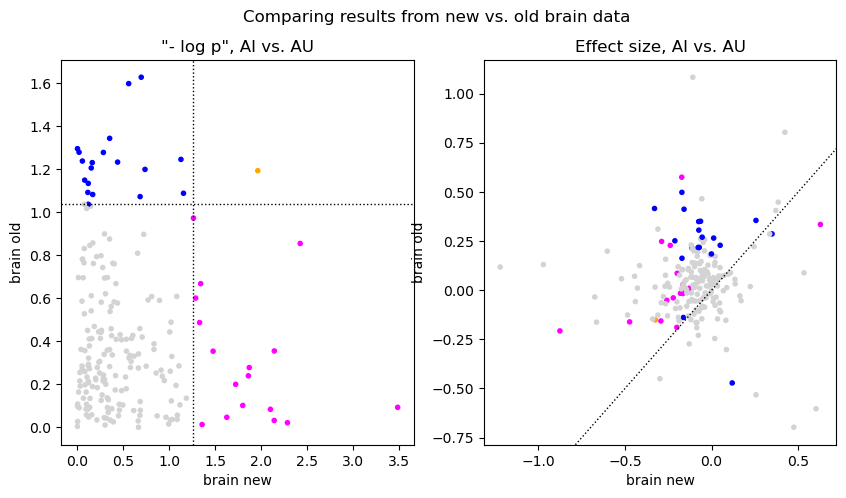

In [30]:
fig, ax = datset_2scatters('brain new', 'brain old', comparison='AI vs. AU', suptitle='Comparing results from new vs. old brain data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'brain_new-brain_old-consistency')

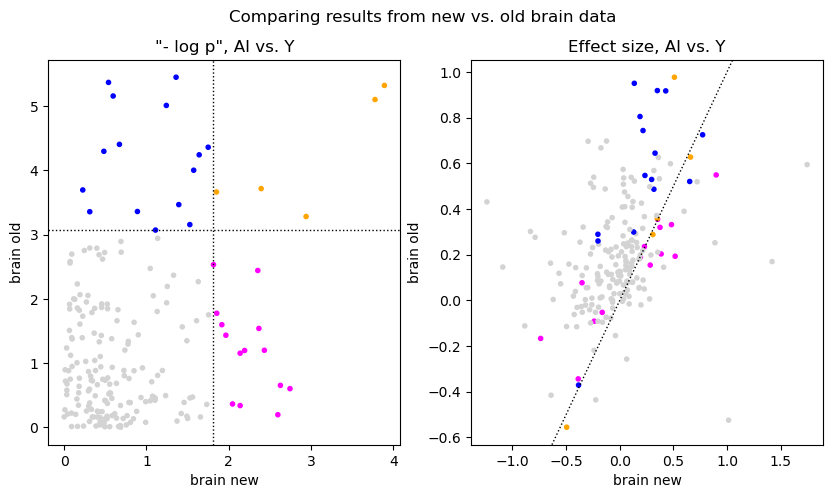

In [31]:
fig, ax = datset_2scatters('brain new', 'brain old', comparison='AI vs. Y', suptitle='Comparing results from new vs. old brain data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'brain_new-brain_old-consistency_AIvsY')

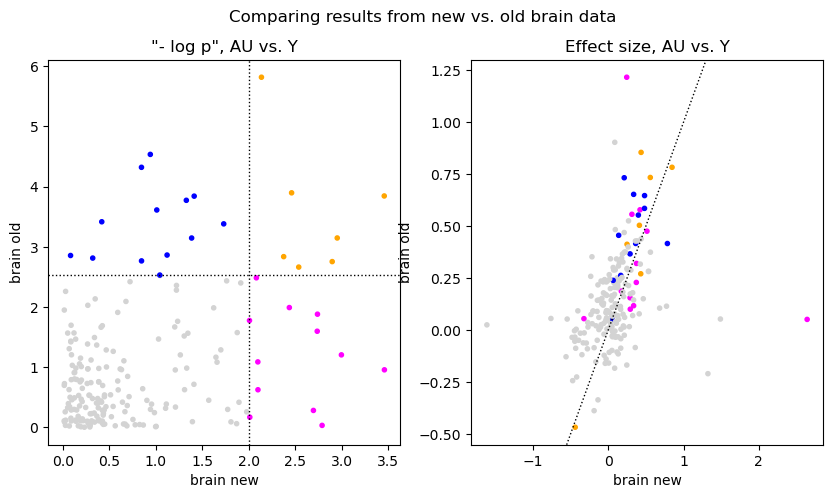

In [32]:
fig, ax = datset_2scatters('brain new', 'brain old', comparison='AU vs. Y', suptitle='Comparing results from new vs. old brain data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'brain_new-brain_old-consistency_AUvsY')

### Comparing results from new vs old blood data

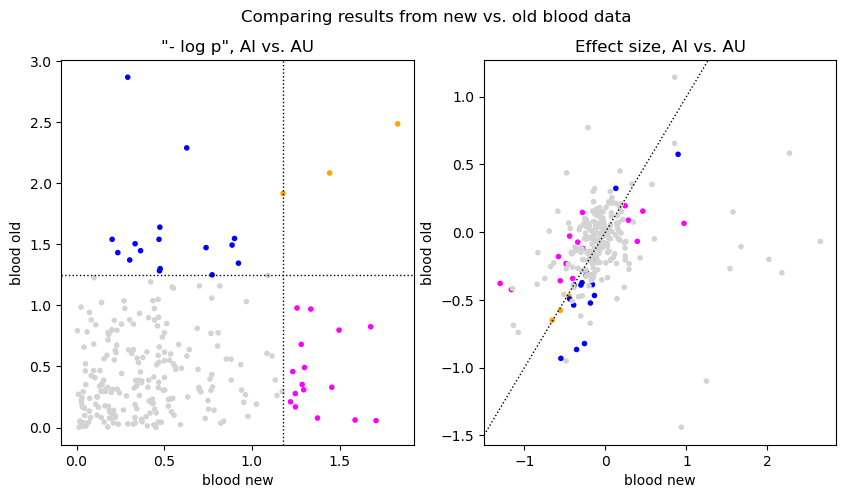

In [33]:
fig, ax = datset_2scatters('blood new', 'blood old', comparison='AI vs. AU', suptitle='Comparing results from new vs. old blood data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'blood_new-blood_old-consistency')

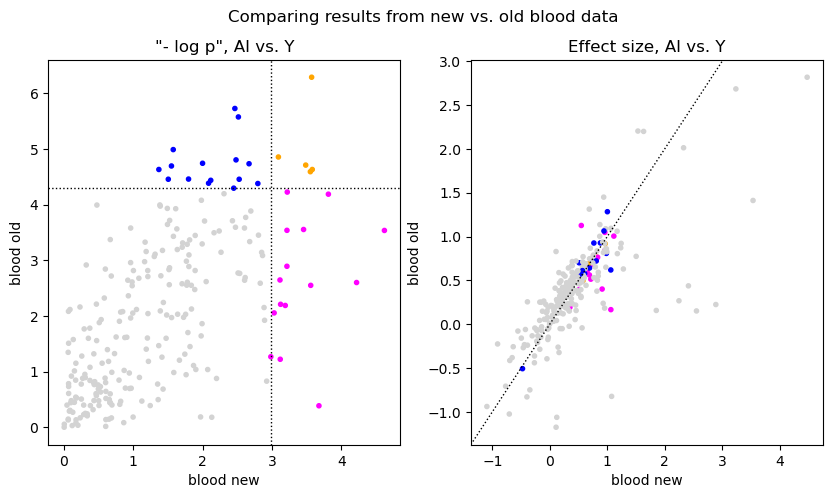

In [34]:
fig, ax = datset_2scatters('blood new', 'blood old', comparison='AI vs. Y', suptitle='Comparing results from new vs. old blood data')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'blood_new-blood_old-consistency_AIvsY')

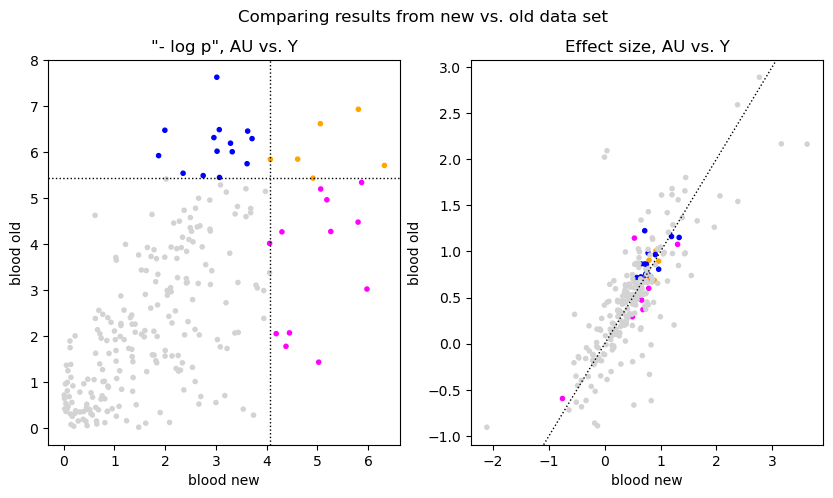

In [35]:
fig, ax = datset_2scatters('blood new', 'blood old', comparison='AU vs. Y', suptitle='Comparing results from new vs. old data set')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'blood_new-blood_old-consistency-AUvsY')

### Comparing results from brain vs blood

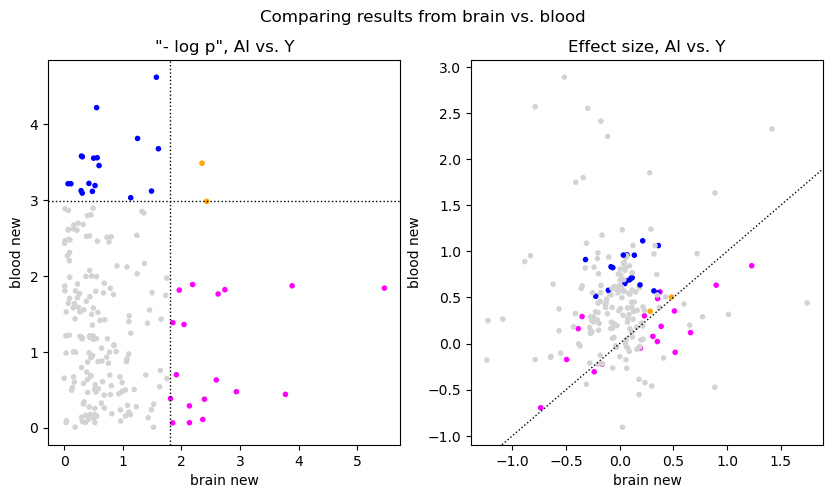

In [36]:
fig, ax = datset_2scatters('brain new', 'blood new', comparison='AI vs. Y', suptitle='Comparing results from brain vs. blood')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'blood_new-brain_new-consistency-AIvsY')

In [37]:
%connect_info

{
  "shell_port": 51764,
  "iopub_port": 51765,
  "stdin_port": 51766,
  "control_port": 51768,
  "hb_port": 51767,
  "ip": "127.0.0.1",
  "key": "6e635fe2-bc33310517f01523856765d0",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-de4c1a32-3a81-40bb-bd21-b378d67700e2.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
